# Text Classification


######  created by - Pancham Desai

### Description:

In a hypothetical scenario, our business is dealing with a large number of documents. Every day we get new and varied articles in the form of messages adding to the text corpus. It is very difficult to manually sift through thousands of articles and organize them into categories for further steps. We want to automate this through NLP and AI based text classification by which we can reduce the effort and time of the manpower involved.   


### About Dataset:
The training dataset contains around 11314 labeled messages and the test dataset contains 7532 messages without a label (the task is to predict these labels). Below is the full list of labels and corresponding topics:

0 - alt.atheism ,
1 - comp.graphics ,
2 - comp.os.ms-windows.misc ,
3 - comp.sys.ibm.pc.hardware ,
4 - comp.sys.mac.hardware ,
5 - comp.windows.x ,
6 - misc.forsale ,
7 - rec.autos ,
8 - rec.motorcycles ,
9 - rec.sport.baseball ,
10 - rec.sport.hockey ,
11 - sci.crypt ,
12 - sci.electronics ,
13 - sci.med ,
14 - sci.space ,
15 - soc.religion.christian ,
16 - talk.politics.guns ,
17 - talk.politics.mideast ,
18 - talk.politics.misc ,
19 - talk.religion.misc ,

### Data fields:

* id - Unique id to a given message
* message - the text of a message
* topic - the label of a message's topic

### Objective:

We have given you the train.csv, test.csv, and sample submission file which consists of the various
articles associated with the topic. The task is to classify text messages from the article dataset to their
corresponding topic.

 
 


In [1]:
#Importing the required Libraries
import numpy as np
import pandas as pd 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import SGDClassifier

In [2]:
#Location of data on disk
path='./Data/train.csv'

In [3]:
#reading the train data using pandas
train_data=pd.read_csv(path,delimiter=',')
train_data

,id,message,topic
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14
...,...,...,...
11309,11309,From: jim.zisfein@factory.com (Jim Zisfein) \r...,13
11310,11310,From: ebodin@pearl.tufts.edu\r\nSubject: Scree...,4
11311,11311,From: westes@netcom.com (Will Estes)\r\nSubjec...,3
11312,11312,From: steve@hcrlgw (Steven Collins)\r\nSubject...,1


In [4]:
#Check for Blank rows 
def missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
    
missing_data = missing_data(train_data)
missing_data

,Total,Percent
topic,0,0.0
message,0,0.0
id,0,0.0


* After observing the above result we come to know that the data is complete.

In [5]:
#check for class imbalance
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(train_data['topic'])

10    5.303164
15    5.294326
8     5.285487
9     5.276648
11    5.258971
13    5.250133
7     5.250133
14    5.241294
5     5.241294
12    5.223617
2     5.223617
3     5.214778
6     5.170585
1     5.161747
4     5.108715
17    4.984974
16    4.825879
0     4.242531
18    4.109952
19    3.332155
Name: topic, dtype: float64

* There is no imbalance in data. The target variable is evenly distributed

## Extracting email id and Body of email from message column

while exploring the data i had observed specific pattern in this email messages i.e the content which states it belongs to particular topic is present in the subject and body of message and hence first i had extracted the senders email from it and stored it in email column And also i had extracted the content that begins after the word 'Subject' and stored it in 'body_clean' column. Hence the information related to topic is stored in 'body_clean' column therefore all the further text processing operations will be performed on body column.

Note: The extracted eamil-id wont be used for modelling but i have saved it so that if required in future we can use it.

In [6]:
#Extracting email id from message
train_data['email']=train_data['message'].str.extract(pat='([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)')

In [7]:
#Extracting body of email message
train_data['body_clean']=train_data['message'].str.partition('Subject')[2]

Now you can observe below that after running the above two lines of code the senders email id and the content after word 'Subject' is separated.

In [8]:
train_data

,id,message,topic,email,body_clean
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,lerxst@wam.umd.edu,: WHAT car is this!?\r\nNntp-Posting-Host: rac...
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu,: SI Clock Poll - Final Call\r\nSummary: Final...
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu,: PB questions...\r\nOrganization: Purdue Univ...
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1,rob@rjck.UUCP,: Re: Weitek P9000 ?\r\nOrganization: Harris C...
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu,: Re: Shuttle Launch Question\r\nOrganization:...
...,...,...,...,...,...
11309,11309,From: jim.zisfein@factory.com (Jim Zisfein) \r...,13,jim.zisfein@factory.com,: Re: Migraines and scans\r\nDistribution: wor...
11310,11310,From: ebodin@pearl.tufts.edu\r\nSubject: Scree...,4,ebodin@pearl.tufts.edu,: Screen Death: Mac Plus/512\r\nLines: 22\r\nO...
11311,11311,From: westes@netcom.com (Will Estes)\r\nSubjec...,3,westes@netcom.com,: Mounting CPU Cooler in vertical case\r\nOrga...
11312,11312,From: steve@hcrlgw (Steven Collins)\r\nSubject...,1,1qkgbuINNs9n@shelley.u.washington.edu,: Re: Sphere from 4 points?\r\nOrganization: C...


## Text Preprocessing

* From here on all the text preprocessing operations will be performed on 'body_clean' column  since the main content of email message which relates it with the target variable 'topic' is stored in 'body_clean' column

### Lower casing of string
* Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.

In [9]:
#Lower case of string
train_data['body_clean']=train_data['body_clean'].str.lower()

### Removal of Frequently appearing word 

* So while going through the messages data i had found the 're:' , '\r\n' was appearing frequently in all email messages. And   it was making no meaning related to topic labels hence thought to remove it.

In [10]:
#Removal of frequently appearing word re 
train_data['body_clean']=train_data['body_clean'].str.replace('re:','')

train_data['body_clean']=train_data['body_clean'].str.replace('\r\n','')

### Removal of Punctuations

* One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat two similar words with same meaning in same way for example : ('hurray' and 'hurray!')
* We also need to carefully choose the list of punctuations to exclude depending on the use case. For example, the string.punctuation in python contains the following punctuation symbols
 !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`

In [11]:
#Removal of punctuations
import string

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
train_data["body_clean"] =train_data["body_clean"].apply(lambda text: remove_punctuation(text))

### Removal of Stop words

* Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis

In [12]:
#Removal of stopwards
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train_data['body_clean'] = train_data["body_clean"].apply(lambda text: remove_stopwords(text))

###  Lemmatization of data

* Lemmatization is done so that to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

In [13]:
#Lemmatization of data
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train_data["body_clean"] = train_data["body_clean"].apply(lambda text: lemmatize_words(text))



In [14]:
#train_data post cleaning
train_data

,id,message,topic,email,body_clean
0,0,From: lerxst@wam.umd.edu (where's my thing)\r\...,7,lerxst@wam.umd.edu,car thisnntppostinghost rac3wamumdeduorganizat...
1,1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guykuo@carson.u.washington.edu,si clock poll final callsummary final call si ...
2,2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,twillis@ec.ecn.purdue.edu,pb questionsorganization purdue university eng...
3,3,From: jgreen@amber (Joe Green)\r\nSubject: Re:...,1,rob@rjck.UUCP,weitek p9000 organization harris computer syst...
4,4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jcm@head-cfa.harvard.edu,shuttle launch questionorganization smithsonia...
...,...,...,...,...,...
11309,11309,From: jim.zisfein@factory.com (Jim Zisfein) \r...,13,jim.zisfein@factory.com,migraine scansdistribution worldorganization i...
11310,11310,From: ebodin@pearl.tufts.edu\r\nSubject: Scree...,4,ebodin@pearl.tufts.edu,screen death mac plus512lines 22organization t...
11311,11311,From: westes@netcom.com (Will Estes)\r\nSubjec...,3,westes@netcom.com,mounting cpu cooler vertical caseorganization ...
11312,11312,From: steve@hcrlgw (Steven Collins)\r\nSubject...,1,1qkgbuINNs9n@shelley.u.washington.edu,sphere 4 pointsorganization central research l...


## Vectorization And Fitting of data using count vectorizer and tf-idf vectorizer

* Now before applying any ML model we need to vectorize the data.There are two process to perform vectorization one is Count vectorizer and another one is tf-idf vectorizer i have decided to try both and see which one does well.

In [15]:
#Tf idf vectorizer approach/Count Vectorizer approach
X=train_data['body_clean'] #Feature column
y=train_data['topic'] # target column

#Train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size = 0.3,random_state=9)

#Intialize count vectorizer approach
count_vectorizer=CountVectorizer()

# initialize tfidf vectorizer
tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,3))


# fit and transform with count vectorizer
X_train_count=count_vectorizer.fit_transform(X_train)

X_test_count=count_vectorizer.transform(X_test)


# fit and transform with tfidf vectorizer
X_train_tfidf= tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf=tfidf_vectorizer.transform(X_test)

## Logistic Regression using Count Vectorizer 

Classification_report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       137
           1       0.77      0.77      0.77       192
           2       0.81      0.80      0.80       191
           3       0.72      0.72      0.72       175
           4       0.84      0.81      0.83       179
           5       0.77      0.86      0.81       183
           6       0.75      0.81      0.78       164
           7       0.83      0.86      0.85       177
           8       0.93      0.91      0.92       170
           9       0.89      0.95      0.92       187
          10       0.97      0.94      0.96       176
          11       0.96      0.91      0.94       176
          12       0.81      0.86      0.84       171
          13       0.92      0.92      0.92       169
          14       0.93      0.92      0.92       193
          15       0.86      0.84      0.85       194
          16       0.91      0.93      0.92       167
    

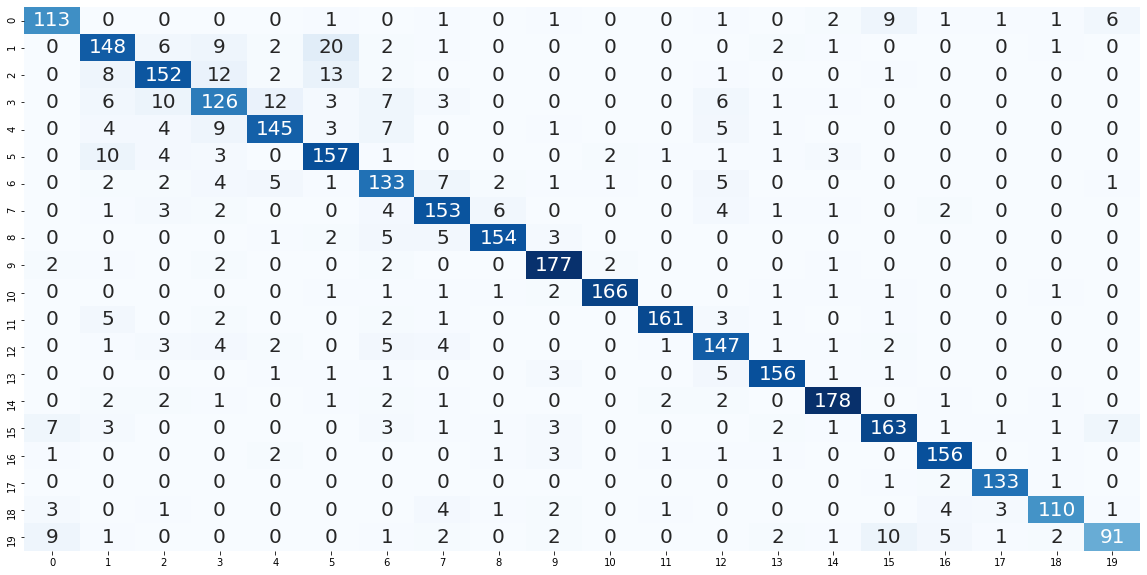

In [16]:
# initialize logistic regression
logreg_1=OneVsRestClassifier(LogisticRegression(random_state=10))


# fit on count vectorizer training data
logreg_1.fit(X_train_count,y_train)

#predict on count vectorizer data
y_pred_count=logreg_1.predict(X_test_count)

class_report=classification_report(y_test,y_pred_count)
print('Classification_report:')
print(class_report)

#f1-score
F1_score=f1_score(y_test,y_pred_count,average='micro')
print('F1 score:')
print(F1_score)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
cm_dtc = confusion_matrix(y_test,y_pred_count)
plt.figure(figsize=(20,10))
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})

## Logistic Regression using tfidf approach

Classification_report for tfidf vectorized data:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       137
           1       0.86      0.80      0.83       192
           2       0.84      0.87      0.86       191
           3       0.72      0.79      0.76       175
           4       0.90      0.84      0.87       179
           5       0.85      0.86      0.85       183
           6       0.72      0.77      0.74       164
           7       0.89      0.90      0.89       177
           8       0.94      0.95      0.94       170
           9       0.96      0.95      0.96       187
          10       0.96      0.96      0.96       176
          11       0.95      0.95      0.95       176
          12       0.87      0.87      0.87       171
          13       0.95      0.93      0.94       169
          14       0.91      0.95      0.93       193
          15       0.75      0.96      0.84       194
          16       0.93      0.9

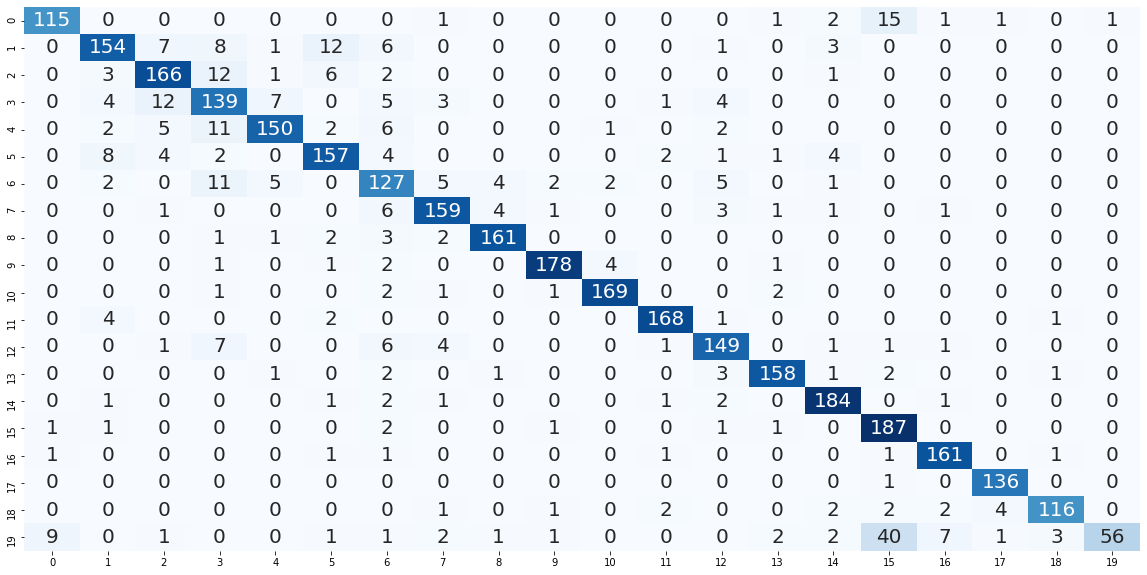

In [17]:
# initialize logistic regression
logreg_2=OneVsRestClassifier(LogisticRegression(random_state=10))

# fit on tf-idf vectorizer training data
logreg_2.fit(X_train_tfidf,y_train)

#predict on tfidf vectorized data
y_pred_tfidf=logreg_2.predict(X_test_tfidf)
             
class_report=classification_report(y_test,y_pred_tfidf)
print('Classification_report for tfidf vectorized data:')
print(class_report)

#Confusion Matrix for tfidf approach
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
cm_dtc = confusion_matrix(y_test,y_pred_tfidf)
plt.figure(figsize=(20,10))
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})


#f1-score
F1_score=f1_score(y_test,y_pred_tfidf,average='micro')
print('F1 score:')
print(F1_score)


***observations***:

* After observing the results of count vectorizer and tfidf approach we can see that the tfidf approach is doing better than count vectorizer approach.Since tfidf give importance to the word occuring frequently in one document and less importance if the same word is occured frequently in other document whereas count vectorizer give importance to words occuring frequently in document.

* Now after observing the good results of tfidf approach i will further try to improve the f1 score and confusion matrix with
  svc classifier since svc classifier often provide good results in text classification

## LinearSVC classifier using tfidf approach

Classification_report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       137
           1       0.87      0.81      0.84       192
           2       0.87      0.88      0.88       191
           3       0.76      0.81      0.79       175
           4       0.90      0.87      0.89       179
           5       0.86      0.90      0.88       183
           6       0.82      0.80      0.81       164
           7       0.90      0.92      0.91       177
           8       0.96      0.97      0.96       170
           9       0.98      0.97      0.97       187
          10       0.96      0.98      0.97       176
          11       0.96      0.97      0.96       176
          12       0.89      0.89      0.89       171
          13       0.94      0.95      0.95       169
          14       0.94      0.97      0.95       193
          15       0.87      0.96      0.91       194
          16       0.95      0.98      0.96       167
    

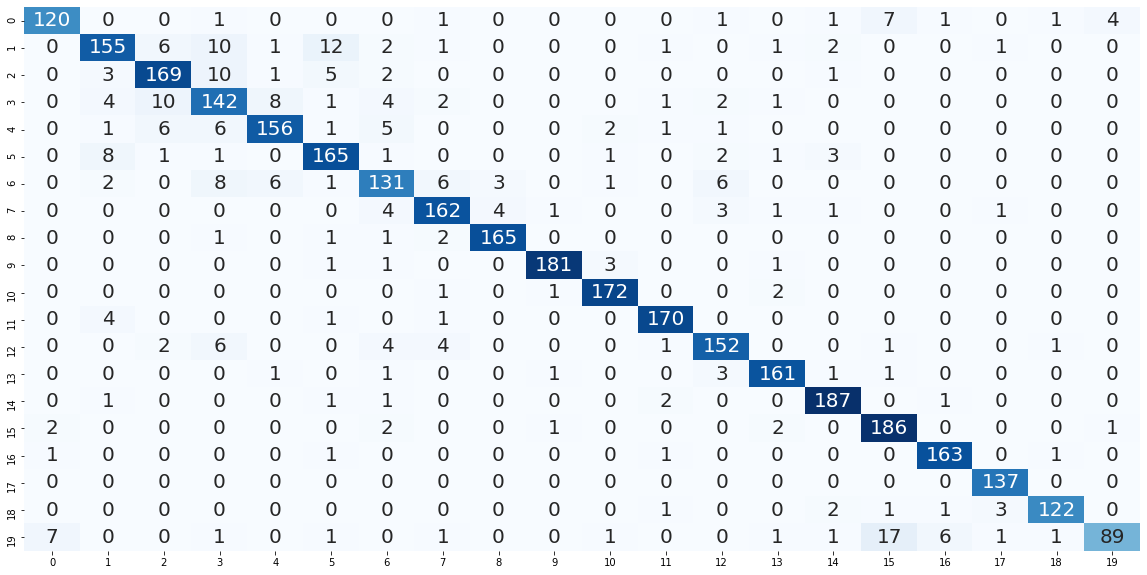

In [16]:
from sklearn.svm import LinearSVC
svc=LinearSVC(random_state=9)

svc.fit(X_train_tfidf,y_train)

#predict on count vectorizer data
y_pred_tfidf_svc=svc.predict(X_test_tfidf)

class_report=classification_report(y_test,y_pred_tfidf_svc)
print('Classification_report:')
print(class_report)

#f1-score
F1_score=f1_score(y_test,y_pred_tfidf_svc,average='micro')
print('F1 score:')
print(F1_score)

#Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
cm_dtc = confusion_matrix(y_test,y_pred_tfidf_svc)
plt.figure(figsize=(20,10))
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 20})

### observations:
* After applying Linear SVC We can see that the there is a lot improvement in confusion matrix also in F1 score as compared to logistic regression tfidf approach
* Hence Linear svc classifier will be used to predict the topic for test data. Since its performance is quite good on the validation set

## TEST DATA

* Now we will repeat all the operations of text extraction & text preprocessing that we have done on train data with test data .

In [17]:
#Location of file on disk
path='./Data/test.csv'

In [18]:
#Loading the test data 
test_data=pd.read_csv(path,delimiter=',')
test_data

,id,message
0,0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...
1,1,From: Rick Miller <rick@ee.uwm.edu>\r\nSubject...
2,2,From: mathew <mathew@mantis.co.uk>\r\nSubject:...
3,3,From: bakken@cs.arizona.edu (Dave Bakken)\r\nS...
4,4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...
...,...,...
7527,7527,From: richmond@spiff.Princeton.EDU (Stupendous...
7528,7528,From: smytonj@murr11.alleg.edu (Jim Smyton)\r\...
7529,7529,From: hhenderson@vax.clarku.edu\r\nSubject: RE...
7530,7530,From: b859zam@utarlg.uta.edu \r\nSubject: INTE...


In [19]:
#Check for Blank rows 
# Function to identify the number of missing values in every feature
def missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
    
missing_data = missing_data(test_data)
missing_data

,Total,Percent
message,0,0.0
id,0,0.0


In [20]:
#Extracting email id from message
test_data['email']=test_data['message'].str.extract(pat='([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)')

In [21]:
#Extracting body of email message
test_data['body_clean']=test_data['message'].str.partition('Subject')[2]

In [22]:
#Cleaning the body_column of test_data


#Lower Casing the text in body column
test_data['body_clean']=test_data["body_clean"].str.lower()

#Removal of frequently appearing word re 
test_data['body_clean']=test_data['body_clean'].str.replace('re:','')

test_data['body_clean']=test_data['body_clean'].str.replace('\r\n','')

#Removal of punctuations
import string

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
test_data["body_clean"] =test_data["body_clean"].apply(lambda text: remove_punctuation(text))


#Removal of numbers
string=test_data['body_clean']

def remove_digits(string):
    return ''.join([i for i in string if not i.isdigit()])

test_data['body_clean']=test_data['body_clean'].apply(lambda string:remove_digits(string))

#Removal of stopwards
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

test_data['body_clean'] = test_data["body_clean"].apply(lambda text: remove_stopwords(text))


#Lemmatization of data
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

test_data["body_clean"] = test_data["body_clean"].apply(lambda text: lemmatize_words(text))



In [23]:
#test data after cleaning
test_data

,id,message,email,body_clean
0,0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,v064mb9k@ubvmsd.cc.buffalo.edu,need info bonnevilleorganization university bu...
1,1,From: Rick Miller <rick@ee.uwm.edu>\r\nSubject...,rick@ee.uwm.edu,xfaceorganization melines distribution worldnn...
2,2,From: mathew <mathew@mantis.co.uk>\r\nSubject:...,mathew@mantis.co.uk,strong weak atheismorganization mantis consult...
3,3,From: bakken@cs.arizona.edu (Dave Bakken)\r\nS...,bakken@cs.arizona.edu,saudi clergy condemns debut human right groupk...
4,4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,livesey@solntze.wpd.sgi.com,year say christian morality isorganization sgi...
...,...,...,...,...
7527,7527,From: richmond@spiff.Princeton.EDU (Stupendous...,richmond@spiff.Princeton.EDU,temperature dark skyoriginator newsnimasternnt...
7528,7528,From: smytonj@murr11.alleg.edu (Jim Smyton)\r\...,smytonj@murr11.alleg.edu,monitor kept hour dayorganization allegheny co...
7529,7529,From: hhenderson@vax.clarku.edu\r\nSubject: RE...,hhenderson@vax.clarku.edu,game length brave updateorganization clark uni...
7530,7530,From: b859zam@utarlg.uta.edu \r\nSubject: INTE...,b859zam@utarlg.uta.edu,intel chmos design kitnewssoftwa vaxvms vnews ...


In [24]:
id=test_data['id']


In [25]:
#Vectoriztion of data
predict_data=test_data['body_clean']
predict_data_tdidf=tfidf_vectorizer.transform(predict_data)

In [26]:
#Prediction on vectorized data
y_pred=svc.predict(predict_data_tdidf)

In [27]:
#Creating a Dataframe of predictions
A=y_pred
A=pd.DataFrame(A)
A

,0
0,7
1,5
2,0
3,17
4,0
...,...
7527,14
7528,4
7529,9
7530,12


In [29]:
#Creating Final Submission file
submissions = pd.concat([id,A], axis=1)
submissions.columns=['id','topic']
#submissions.to_csv('submission.csv', index=False)
submissions

,id,topic
0,0,7
1,1,5
2,2,0
3,3,17
4,4,0
...,...,...
7527,7527,14
7528,7528,4
7529,7529,9
7530,7530,12
